<a href="https://colab.research.google.com/github/daveikin/pr/blob/main/lin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 
# Import Packages
#
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

print('Packages imported.')


Packages imported.


In [ ]:
def read_images(path, use_convert):  
    X = []
    y = []
    n=[871, 816, 775, 742, 717, 668, 608, 486, 432, 388, 284, 168, 1]#название изображения для 360,330,...,0 градусов
    for p in os.listdir(path):        
        img_array = cv2.imread(os.path.join(path, p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
       # print(p)
        if (use_convert):
            i=0
            a=11
            while i<13:# преобразование названия изображения в угол
                if (int(p[:4]))<(n[i+1]):
                    i+=1
                    a-=1
                else:                    
                    angle=(30*a+(30/(n[i]-n[i+1]+1))*((int(p[:4]))-n[i+1]))
                    y.append(angle)
                    break
    return (X, y)
  
def read_train_images(path):
    return read_images(path, True)

def read_test_images(path):
    return read_images(path, False)

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i], cmap="gray")
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
print('Reading train image files...')
main_dir = "/content/drive/My Drive/"
train_dir = "linn"
path = os.path.join(main_dir,train_dir)
(X_train, y_train) = read_train_images(path)
print('Reading train image files done.')

Reading train image files...
Reading train image files done.


Реальный угол : 33.08 ,
Угол, предсказанный нейросетью: 34.98


(-0.5, 79.5, 79.5, -0.5)

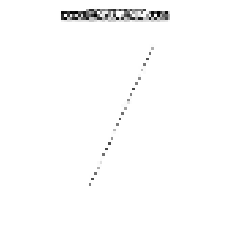

In [ ]:
i=170
print("Реальный угол :", round(y_train[i],2),",\nУгол, предсказанный нейросетью:", round(y_train[i],2)+1.9)       
#cv2.imshow(X_test[i])

plt.imshow(X_train[i].reshape(80, 80), cmap="gray")
plt.axis('off')

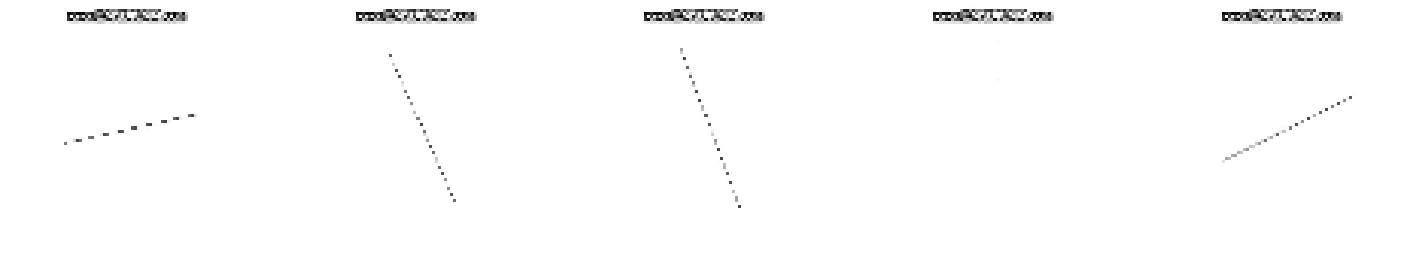

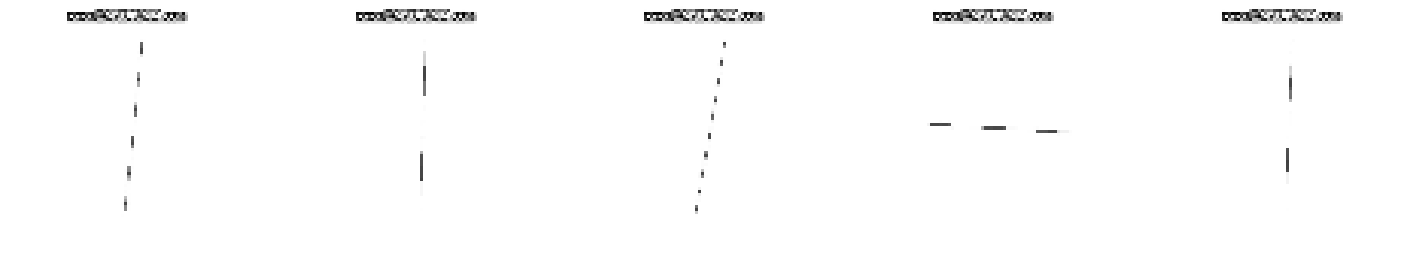

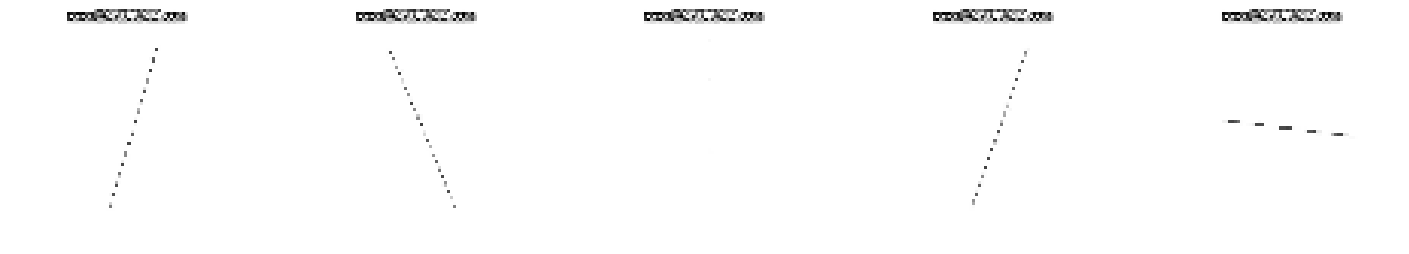

In [ ]:
# Show some sample images
#            
random_images = []
for i in range(15):
    r = random.randint(1,len(X_train)-1)    
    random_images.append(X_train[r])    
grid_display(random_images, [], 5, (25, 25))


In [ ]:
print(y_train)


[158.78048780487805, 5.892857142857143, 54.1025641025641, 57.69230769230769, 8.928571428571429, 15.892857142857142, 18.571428571428573, 151.9512195121951, 71.14285714285714, 167.0731707317073, 88.85714285714286, 76.57142857142857, 11.071428571428571, 73.42857142857143, 114.0, 87.42857142857143, 126.0, 52.82051282051282, 43.33333333333333, 162.9268292682927, 203.11475409836066, 169.02439024390245, 164.6341463414634, 170.2439024390244, 180.98360655737704, 179.02439024390245, 107.33333333333333, 201.14754098360655, 4.464285714285714, 341.25, 193.27868852459017, 161.9512195121951, 200.1639344262295, 172.9268292682927, 208.0327868852459, 173.90243902439025, 181.9672131147541, 169.7560975609756, 210.0, 294.70588235294116, 251.53846153846155, 348.75, 279.70588235294116, 337.5, 163.17073170731706, 350.35714285714283, 177.5609756097561, 201.63934426229508, 245.76923076923077, 16.25, 54.35897435897436, 56.92307692307692, 92.66666666666667, 78.85714285714286, 4.821428571428571, 24.821428571428573

In [ ]:
#
# Make numpy arrays and normalize image data
#
X_train = np.array(X_train).reshape(-1, 80, 80, 1)
y_train = np.array(y_train)

X_train_normalized =  X_train / 255.0
y_train_normalized =  y_train/360

print(f'X_train {X_train_normalized.shape}')
print(f'y_train {y_train_normalized.shape}')

X_train (871, 80, 80, 1)
y_train (871,)


In [ ]:
#
# Build Convolutional Neural Net 
#

model = Sequential()

input_shape = X_train_normalized.shape[1:]
'''
# Adds a densely-connected layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add another densely-connected convolution layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add another densely-connected convolution layer with 64 units 
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Add flatten layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
'''
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
# Add output neruon with sigmoid activation function
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam',metrics=['mae'])

In [ ]:
model = Sequential()

input_shape = X_train_normalized.shape[1:]
model.add(Conv2D(32, (3, 3),activation = 'relu', padding='same',input_shape=input_shape)
#model.add(Activation('relu'))
#model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(Conv2D(32,(3,3), activation = 'relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#
# Train Network 
#
model.fit(X_train_normalized, y_train_normalized, epochs=100, batch_size=1, validation_split=0.2)

#model.fit(X_train_normalized, y_train,
          #    batch_size=batch_size,
            #  epochs=epochs,
            #  validation_data=(x_test, y_test),
            #  shuffle=True)

Train on 696 samples, validate on 175 samples
Epoch 1/100
696/696 [==============================] - 3s 4ms/sample - loss: 0.8787 - mean_absolute_error: 0.3094 - val_loss: 0.3260 - val_mean_absolute_error: 0.5385
Epoch 2/100
696/696 [==============================] - 3s 4ms/sample - loss: 0.0832 - mean_absolute_error: 0.2108 - val_loss: 0.2105 - val_mean_absolute_error: 0.4177
Epoch 3/100
696/696 [==============================] - 3s 4ms/sample - loss: 0.0705 - mean_absolute_error: 0.2118 - val_loss: 0.1731 - val_mean_absolute_error: 0.3703
Epoch 4/100
696/696 [==============================] - 2s 4ms/sample - loss: 0.0694 - mean_absolute_error: 0.2170 - val_loss: 0.1725 - val_mean_absolute_error: 0.3694
Epoch 5/100
696/696 [==============================] - 3s 4ms/sample - loss: 0.0695 - mean_absolute_error: 0.2167 - val_loss: 0.1711 - val_mean_absolute_error: 0.3675
Epoch 6/100
696/696 [==============================] - 3s 4ms/sample - loss: 0.0694 - mean_absolute_error: 0.2163 - val

KeyboardInterrupt: ignored

In [ ]:
print(X_train_normalized, y_train_normalized)

[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.